In [1]:
import numpy as np
import torch

import sys
sys.path.insert(1,"../scripts")
from get_voxels import get_mol_voxels
from networks import Encoder, UNet3D, EncoderCNN, DecoderRNN

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import itertools
from diffusers import DDPMScheduler
from typing import List, Optional, Tuple, Union

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

encoder = Encoder()
encoder.load_state_dict(torch.load("../models/state_dict_encoder.pt"))

net = UNet3D(in_channels=5, num_classes=5)
net.load_state_dict(torch.load("../models/state_dict_net.pt"))
# Initialize the DDPM scheduler
ddpm = DDPMScheduler(num_train_timesteps=1000)

#Load Encoding and Captioning Networks (from Ligdream)
encoderCNN = EncoderCNN(5)
encoderCNN.load_state_dict(torch.load("../models/encoder-210000.pkl",map_location="cpu"))
decoder = DecoderRNN(512, 1024, 29, 1)
decoder.load_state_dict(torch.load("../models/decoder-210000.pkl", map_location='cpu'))
use_cuda = True

encoder.to(device)
net.to(device)

Using device: cuda


# Generate from Random Noise, unconditional

Puts random noise through the unet.

Gets prediction > Adds prediction to noise with mix factor > repeats for n_steps

Iteratively denoises initial blur

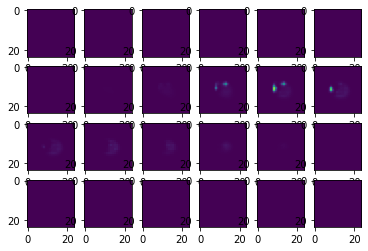

In [16]:
n_steps = 50
x = torch.rand(1,5,24,24,24).to(device) # Start from random
# x = input[0]
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad(): # No need to track gradients during inference
        pred = net(x) # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu()) # Store model output for plotting
    mix_factor = 1/(n_steps - i) # How much we move towards the prediction
    x = x*(1-mix_factor) + pred*mix_factor # Move part of the way there
    step_history.append(x.detach().cpu()) # Store step for plotting

torch.save(pred.cpu(), "predicted_shape.pkl")

# pred -= pred.min(1, keepdim=True)[0]
# pred /= pred.max(1, keepdim=True)[0]

try:
    pred = pred.cpu().detach().numpy()
except:
    print("Already on cpu")

# pred = channels

fields = [pred[0][0][i] for i in range(24)]

combined_data = np.array(fields)
#Get the min and max of all your data
_min, _max = np.amin(combined_data), np.amax(combined_data)

fig, axs = plt.subplots(4,6)

j = 2

for i in range(24):
    if i < 6:
        axs[0,i].imshow(pred[0][j][i],cmap="viridis", vmin = _min, vmax = _max)
    if i>= 6 and i < 12:
        axs[1,i-6].imshow(pred[0][j][i],cmap="viridis", vmin = _min, vmax = _max)
    if i>= 12 and i < 18:
        axs[2,i-12].imshow(pred[0][j][i],cmap="viridis", vmin = _min, vmax = _max)
    if i>= 18:
        axs[3,i-18].imshow(pred[0][j][i],cmap="viridis", vmin = _min, vmax = _max)

## Visualise Pharmacophore encoder performance

In [1]:
origs = []
pred_y = []
smiles = ["CCN(CC)CCCC(C)NC1=C2C=CC(=CC2=NC=C1)Cl",
        "CC1C(C(C)C)C2=C(C=C(C)C(C(C)=O)=C2)C1(C)C",
        "CC1=CC2=C(C(=CN2CC3=C(C(=NC=N3)N(C)C)C)C(=O)NCCO)N=C1",
        "COC(=O)NC(=O)C1=C(SC=C1)NC(=O)C2=CC=C(C=C2)C(=O)N3CCCCC3",
        "C1C2CC3CC1CC(C2)C3NC(=O)C4=CC(=CN4)C5=C(N=C(C=C5)F)F",
        "CCCN1C=NC2=C1C=CC(=C2)NCC3=C(C=C(C=C3)Cl)Cl "]
for i in range(len(smiles)):
    x_ref, y = get_mol_voxels(smiles[i])
    pharm_pred = encoder(torch.tensor(x_ref).reshape(-1,5,24,24,24).to(device))
    origs.append(y.cpu().detach().numpy())
    pred_y.append(pharm_pred.cpu().detach().numpy())


# Plot comparisons of individual slices

figs, axs = plt.subplots(nrows=6,ncols=6,figsize=(10,12))

layer = 15

for ax,i in zip(axs[0],range(6)):
    ax.imshow(origs[i][0][layer])
axs[0,0].set_ylabel("Ground Truth")
axs[0,0].set_title("Aromatics Channel")
for ax,i in zip(axs[1],range(6)):
    ax.imshow(pred_y[i][0][0][layer])
axs[1,0].set_ylabel("Predicted")

for ax,i in zip(axs[2],range(6)):
    ax.imshow(origs[i][1][layer])
axs[2,0].set_ylabel("Ground Truth")
axs[2,0].set_title("H-bond donors")
for ax,i in zip(axs[3],range(6)):
    ax.imshow(pred_y[i][0][1][layer])
axs[3,0].set_ylabel("Predicted")

for ax,i in zip(axs[4],range(6)):
    ax.imshow(origs[i][2][layer])
axs[4,0].set_ylabel("Ground Truth")
axs[4,0].set_title("H-bond acceptors")
for ax,i in zip(axs[5],range(6)):
    ax.imshow(pred_y[i][0][2][layer])
axs[5,0].set_ylabel("Predicted")

plt.show()

NameError: name 'get_mol_voxels' is not defined

Plot from random noise with conditioning

In [6]:
loss_fn = torch.nn.MSELoss

In [7]:
def scale_model_input(sample: torch.FloatTensor, timestep: Optional[int] = None) -> torch.FloatTensor:
    """
    Ensures interchangeability with schedulers that need to scale the denoising model input depending on the
    current timestep.

    Args:
        sample (`torch.FloatTensor`): input sample
        timestep (`int`, optional): current timestep

    Returns:
        `torch.FloatTensor`: scaled input sample
    """
    return sample


In [64]:
gen_num = 64
vox2vox = True
guidance_loss_scale = 100  # Explore changing this to 5, or 100
timesteps = 50

x_ref, y = get_mol_voxels("C1CC1C(=O)NC2=CC=CC(=C2)NC3=NC=NC(=C3)NC4=CC=CC(=C4)C(F)(F)F")


ddpm.set_timesteps(timesteps)
if vox2vox:
    x = x_ref.reshape(-1,5,24,24,24).to(device)
    x = torch.cat([x]*gen_num)
    noise = torch.rand(x.shape).to(device)
    x = x*0.9+noise*0.1
else:
    x = torch.randn(gen_num, 5, 24,24,24).to(device)


y = y.reshape(-1,3,24,24,24).to(device)
y= torch.cat([y]*gen_num)

for i, t in enumerate(ddpm.timesteps):

    # Prepare the model input
    model_input = scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = net(model_input)

    # Set x.requires_grad to True
    x = x.detach().requires_grad_(True)

    # Get the predicted x0
    x0 = ddpm.step(noise_pred, t, x)["prev_sample"] #.pred_original_sample

    # Calculate loss

    pred_pharm = encoder(x0)
    loss = torch.nn.functional.mse_loss(y,pred_pharm)*guidance_loss_scale*gen_num

    if i % 10 == 0:
        print(i, loss)

    # Get gradient

    cond_grad = -torch.autograd.grad(loss, x)[0]

    # Modify x based on this gradient
    x = x.detach() + cond_grad

    # Now step with scheduler
    x = ddpm.step(noise_pred, t, x)["prev_sample"]

0 tensor(618.5059, device='cuda:0', grad_fn=<MulBackward0>)
10 tensor(817.4987, device='cuda:0', grad_fn=<MulBackward0>)
20 tensor(878.8433, device='cuda:0', grad_fn=<MulBackward0>)
30 tensor(907.3829, device='cuda:0', grad_fn=<MulBackward0>)
40 tensor(917.8343, device='cuda:0', grad_fn=<MulBackward0>)


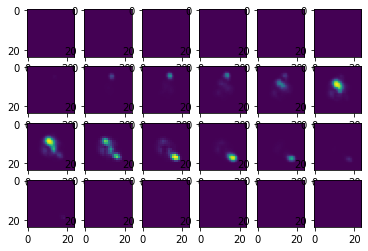

In [65]:
try:
    pred = noise_pred.cpu().detach().numpy()
except:
    None

fields = [pred[0][0][i] for i in range(24)]

combined_data = np.array(fields)
#Get the min and max of all your data
_min, _max = np.amin(combined_data), np.amax(combined_data)

fig, axs = plt.subplots(4,6)

j = 0
for i in range(24):
    if i < 6:
        axs[0,i].imshow(pred[0][j][i],cmap="viridis", vmin = _min, vmax = _max)
    if i>= 6 and i < 12:
        axs[1,i-6].imshow(pred[0][j][i],cmap="viridis", vmin = _min, vmax = _max)
    if i>= 12 and i < 18:
        axs[2,i-12].imshow(pred[0][j][i],cmap="viridis", vmin = _min, vmax = _max)
    if i>= 18:
        axs[3,i-18].imshow(pred[0][j][i],cmap="viridis", vmin = _min, vmax = _max)

In [55]:
import plotly.graph_objects as go
import numpy as np
import itertools

test = x_ref.numpy().reshape(-1,5,24,24,24)

X,Y,Z = [list(np.arange(d)) for d in (24,24,24) ]
voxels = list(itertools.product(X,Y,Z))
isoval = [test[0][3][i][j][k] for i,j,k in voxels]
voxels = np.array(voxels)
X, Y, Z = [voxels[:,i] for i in range(3)]

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value = isoval,
    isomin=0.1,
    isomax=1.0,
    opacity=0.05, # needs to be small to see through all surfaces
    surface_count=21, # needs to be a large number for good volume rendering
    ))
fig.show()

In [54]:
import plotly.graph_objects as go
import numpy as np
import itertools

X,Y,Z = [list(np.arange(d)) for d in (24,24,24) ]
voxels = list(itertools.product(X,Y,Z))
isoval = [pred[48][3][i][j][k] for i,j,k in voxels]
voxels = np.array(voxels)
X, Y, Z = [voxels[:,i] for i in range(3)]

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value = isoval,
    isomin=0.1,
    isomax=1.0,
    opacity=0.05, # needs to be small to see through all surfaces
    surface_count=64, # needs to be a large number for good volume rendering
    ))
fig.show()

Decoder and Captioning

In [11]:
#Load Encoding and Captioning Networks (from Ligdream)
encoderCNN = EncoderCNN(5)
encoderCNN.load_state_dict(torch.load("../models/encoder-210000.pkl",map_location="cpu"))
decoder = DecoderRNN(512, 1024, 29, 1)
decoder.load_state_dict(torch.load("../models/decoder-210000.pkl", map_location='cpu'))
use_cuda = True

In [13]:
# Copyright (C) 2019 Computational Science Lab, UPF <http://www.compscience.org/>
# Copying and distribution is allowed under AGPLv3 license

vocab_list = ["pad", "start", "end",
    "C", "c", "N", "n", "S", "s", "P", "O", "o",
    "B", "F", "I",
    "Cl", "[nH]", "Br", # "X", "Y", "Z",
    "1", "2", "3", "4", "5", "6",
    "#", "=", "-", "(", ")"  # Misc
]

vocab_i2c_v1 = {i: x for i, x in enumerate(vocab_list)}
vocab_c2i_v1 = {vocab_i2c_v1[i]: i for i in vocab_i2c_v1}

In [66]:
# pred = torch.randn(noise_pred.shape)

pred = noise_pred

encoderCNN.to("cpu")
decoder.to("cpu")
pred = pred.to("cpu")

smiles_gen = []
for predict in pred:
    embedding = encoderCNN(predict.reshape(-1,5,24,24,24))
    # embedding = encoderCNN(torch.tensor(x_ref).reshape(-1,5,24,24,24))

    captions = decoder.sample(embedding)
    captions = [captions]

    gen_smiles = []
    for sample in captions:
        csmile = ""
        for xchar in sample[0:]:
            if xchar == 1:
                continue
            if xchar == 2:
                break
            csmile += [i for i in vocab_c2i_v1 if vocab_c2i_v1[i]==xchar][0]
        gen_smiles.append(csmile)

    smiles_gen = smiles_gen+gen_smiles

In [57]:
baseline_noise = smiles_gen

In [58]:
print(len(smiles_gen))

smiles_gen = [a for a in smiles_gen if a not in baseline_noise]
print(len(smiles_gen))

64
0


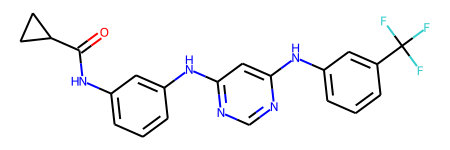

In [60]:
Chem.MolFromSmiles("C1CC1C(=O)NC2=CC=CC(=C2)NC3=NC=NC(=C3)NC4=CC=CC(=C4)C(F)(F)F")

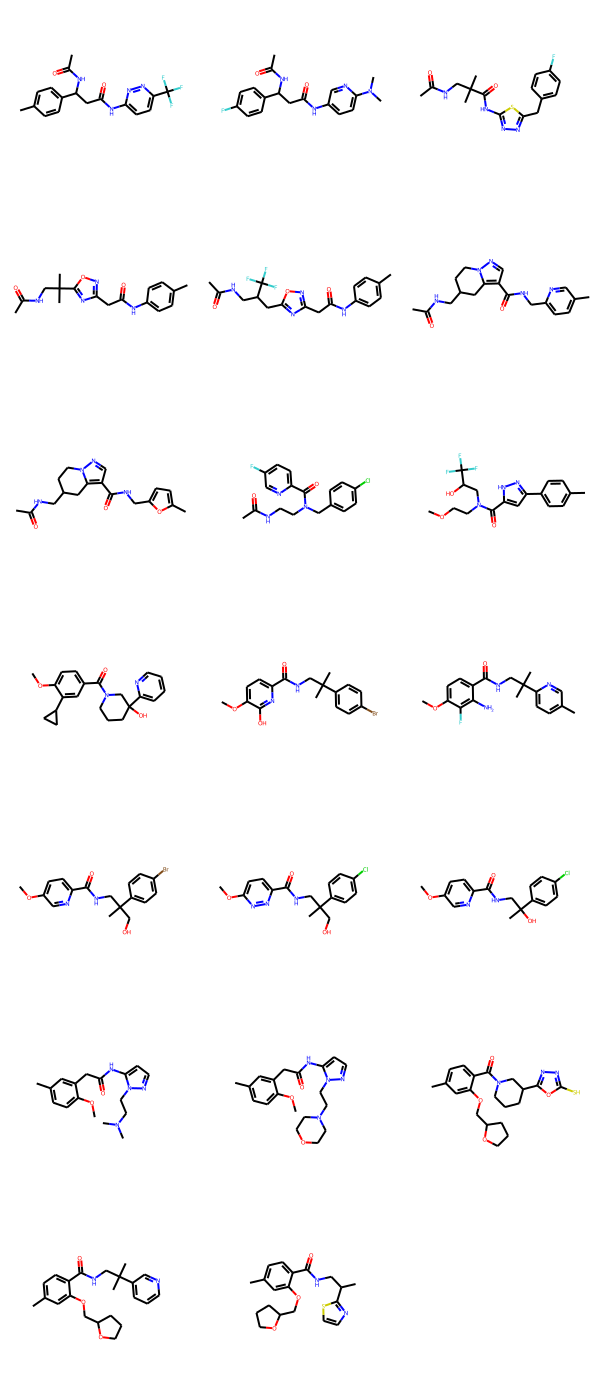

In [67]:
from rdkit import Chem

mols = [Chem.MolFromSmiles(x) for x in np.unique(np.array(smiles_gen))]
Chem.Draw.MolsToGridImage(mols)